In [1]:
import numpy as np
import lqrpols
import matplotlib.pyplot as plt

In [2]:
# state transition matrices for linear system: 
#     x(t+1) = A x (t) + B u(t)
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])
d,p = B.shape

# LQR quadratic cost per state
Q = np.array([[1,0],[0,0]])

# initial condition for system
z0 = -1 # initial position
v0 = 0  # initial velocity
x0 = np.vstack((z0,v0))

R = np.array([[1.0]])

# number of time steps to simulate
T = 10

# amount of Gaussian noise in dynamics
eq_err = 1e-2


In [3]:
N_vals = np.floor(np.logspace(0.0,2.7,num=6)).astype(int)
N_trials = 10

### Bunch of matrices for storing costs
J_finite_nom = np.zeros((N_trials,len(N_vals)))
J_finite_nomK = np.zeros((N_trials,len(N_vals)))
J_finite_rs = np.zeros((N_trials,len(N_vals)))
J_finite_ur = np.zeros((N_trials,len(N_vals)))
J_finite_pg = np.zeros((N_trials,len(N_vals)))
J_inf_nom = np.zeros((N_trials,len(N_vals)))
J_inf_rs = np.zeros((N_trials,len(N_vals)))
J_inf_ur = np.zeros((N_trials,len(N_vals)))
J_inf_pg = np.zeros((N_trials,len(N_vals)))


# cost for finite time horizon, true model
J_finite_opt = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A,B)

### Solve for optimal infinite time horizon LQR controller
K_opt = -lqrpols.lqr_gain(A,B,Q,R)
# cost for infinite time horizon, true model
J_inf_opt = lqrpols.cost_inf_K(A,B,Q,R,K_opt) 

# cost for zero control
baseline = lqrpols.cost_finite_K(A,B,Q,R,x0,T,np.zeros((p,d)))/J_finite_opt-1;

# model for nominal control with 1 rollout
A_nom,B_nom = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,1,T)

# cost for finite time horizon, one rollout, nominal control
one_rollout_cost = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)/J_finite_opt-1;

for N in range(len(N_vals)):
    for trial in range(N_trials):
        
        # nominal model, N x 40 to match sample budget of policy gradient
        A_nom,B_nom = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,N_vals[N]*40,T);
        # finite time horizon cost with nominal model
        J_finite_nom[trial,N] = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)/J_finite_opt-1
        # Solve for infinite time horizon nominal LQR controller
        K_nom = -lqrpols.lqr_gain(A_nom,B_nom,Q,R)
        # cost of using the infinite time horizon solution for finite time horizon
        J_finite_nomK[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_nom)/J_finite_opt-1
        # infinite time horizon cost of nominal model
        J_inf_nom[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_nom)/J_inf_opt-1

        # policy gradient, batchsize 40 per iteration
        K_pg = lqrpols.policy_gradient_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N],T)
        J_finite_pg[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_pg)/J_finite_opt-1
        J_inf_pg[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_pg)/J_inf_opt-1
        
        # random search, batchsize 4, so uses 8 rollouts per iteration
        K_rs = lqrpols.random_search_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_rs[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_rs)/J_finite_opt-1
        J_inf_rs[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_rs)/J_inf_opt-1

        # uniformly random sampling, N x 40 to match sample budget of policy gradient
        K_ur = lqrpols.uniform_random_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*40,T)
        J_finite_ur[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_ur)/J_finite_opt-1
        J_inf_ur[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_ur)/J_inf_opt-1

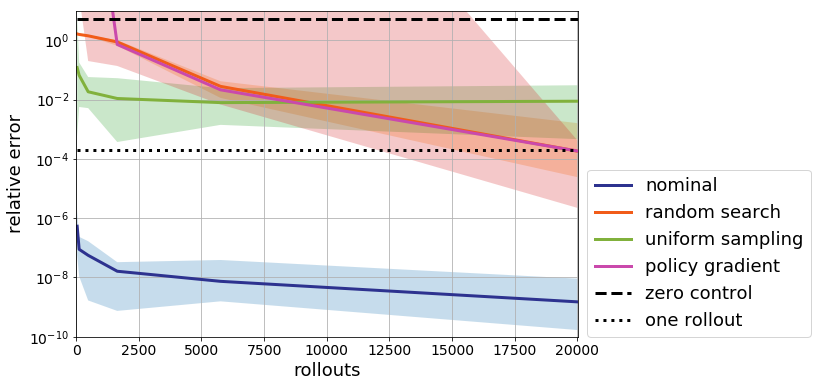

In [4]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3

plt.semilogy(40*N_vals,np.median(J_finite_nom,axis=0),color=colors[0],linewidth=linewidth,label='nominal')
plt.fill_between(40*N_vals, np.amin(J_finite_nom,axis=0), np.amax(J_finite_nom,axis=0), alpha=0.25)

plt.semilogy(40*N_vals,np.median(J_finite_rs,axis=0),color=colors[1],linewidth=linewidth,label='random search')
plt.fill_between(40*N_vals, np.amin(J_finite_rs,axis=0), np.amax(J_finite_rs,axis=0), alpha=0.25)

plt.semilogy(40*N_vals,np.median(J_finite_ur,axis=0),color=colors[2],linewidth=linewidth,label='uniform sampling')
plt.fill_between(40*N_vals, np.amin(J_finite_ur,axis=0), np.amax(J_finite_ur,axis=0), alpha=0.25)

plt.semilogy(40*N_vals,np.median(J_finite_pg,axis=0),color=colors[3],linewidth=linewidth,label='policy gradient')
plt.fill_between(40*N_vals, np.amin(J_finite_pg,axis=0), np.amax(J_finite_pg,axis=0), alpha=0.25)

plt.semilogy([40*N_vals[0],40*N_vals[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.semilogy([40*N_vals[0],40*N_vals[-1]],[one_rollout_cost, one_rollout_cost],color='#000000',linewidth=linewidth,
             linestyle=':',label='one rollout')

y_lo = 10**(np.floor(np.log10(np.amin(J_finite_nom))))
plt.axis([0,40*N_vals[-1],y_lo,10])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('relative error',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)


plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

In [6]:
N_vals*5

array([   5,   15,   60,  205,  720, 2505])

In [5]:
np.median(J_finite_pg,axis=0)

array([  2.81567625e+03,   2.06573211e+10,   4.15202520e+04,
         2.06489703e+10,   2.64602081e-02,   6.91849297e-05])

In [6]:
np.median(J_finite_rs,axis=0)

array([  1.62600578e+00,   1.55489356e+00,   1.40504563e+00,
         5.77754649e-01,   1.29413650e-02,   2.20638722e-04])

In [25]:
K_rs = lqrpols.random_search_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T, 1e-2, 7e-1, 4 )
J_finite_opt = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A,B)
print(lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_rs)/J_finite_opt-1)


[ 0.00011145]


In [98]:
def random_search_linear_policy2(A,B,Q,R,x0,eq_err,N,T,
    explore_mag = 1e-2, step_size = 5e-1, batch_size = 4, ss_decay = 1800):
  '''
    Arguments:
      state transition matrices (A,B)
      LQR Costs (Q,R)
      Initial State x0
      magnitude of noise in dynamics eq_err
      Number of rollouts N
      Time Horizon T

      hyperparameters:
        explore_mag = magnitude of the noise to explore
        step_size
        batch_size = number of directions per minibatches
        safeguard: maximum absolute value of entries of controller gain

    Outputs:
      Static Control Gain K optimized on LQR cost by random search
  '''

  d,p = B.shape

  # initial condition for K
  K0 = 1e-3*np.random.randn(p,d)
  ###

  #### ALGORITHM
  K = K0
  for k in range(N):
    reward_store = []
    mini_batch = np.zeros((p,d))
    for j in range(batch_size):
      V = explore_mag*np.random.randn(p,d)
      for sign in [-1,1]:
        x = x0
        reward = 0
        for t in range(T):
          u = np.dot(K+sign*V,x)
          x = A.dot(x)+B.dot(u)+eq_err*np.random.randn(d,1)
          reward += -np.dot(x.T,Q.dot(x))-np.dot(u.T,R.dot(u))
        mini_batch += (reward*sign)*V
        reward_store.append(reward)
    if k>2000:
        step_size_use = step_size*0.1;
    else:
        step_size_use = step_size

    K += (step_size_use/batch_size/np.std(reward_store))*mini_batch

  return K

In [113]:
q=np.zeros((10))
for k in range(10):
    K_rs = random_search_linear_policy2(A,B,Q,R,x0,eq_err,N_vals[N]*5,T, 4e-2, 5e-1, 4,2000)
    J_finite_opt = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A,B)
    q[k]=lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_rs)/J_finite_opt-1
    print(q[k])

3.23489424565e-05
3.73630463009e-05
0.000128288843184
5.84402050801e-05
0.000616624579582
0.000276484904654
0.000388268130274
0.000294703676477
0.000506934161552
0.00110293962465


In [90]:
N_vals[N]*5

2505

In [93]:
np.median([ 0.00047319, 0.00059878, 0.00194551, 0.01116898, 0.00017876, 0.00124901, 0.00025277, 0.00269621, 0.0012431, 0.00030498])

0.00092094000000000008

In [114]:
np.median(q)/6.91849297e-05

4.1279841116253415